In [3]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 4.6 MB/s eta 0:00:00


In [4]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.7 MB/s eta 0:00:00


In [5]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score,
                             confusion_matrix, roc_auc_score, matthews_corrcoef)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import KNNImputer

In [6]:
# --- uyarıları kapatma ---
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", module="lightgbm")

In [8]:
# --- read csv ---
data = pd.read_csv("kepler.csv", comment='#')

# Their Strategy

## Without Stellar features

In [6]:
# --- feature columns ---
# df_kp = data[['koi_disposition',
#               'koi_pdisposition', 'koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss',
#               'koi_fpflag_co', 'koi_fpflag_ec', 'koi_period', 'koi_impact',
#               'koi_duration', 'koi_depth',
#               'koi_prad', 'koi_teq', 'koi_insol',
#               'koi_model_snr', 'koi_tce_plnt_num',
#               'koi_steff',
#               'koi_slogg', 'koi_srad',
#               'ra', 'dec', 'koi_kepmag']]

df_kp = data[['koi_pdisposition','koi_period', 'koi_time0bk', 'koi_duration', 'koi_depth', 'koi_teq',
'koi_prad', 'koi_insol']]

In [7]:
df_kp

,koi_pdisposition,koi_period,koi_time0bk,koi_duration,koi_depth,koi_teq,koi_prad,koi_insol
0,CANDIDATE,9.488036,170.538750,2.95750,615.8,793.0,2.26,93.59
1,CANDIDATE,54.418383,162.513840,4.50700,874.8,443.0,2.83,9.11
2,CANDIDATE,19.899140,175.850252,1.78220,10829.0,638.0,14.60,39.30
3,FALSE POSITIVE,1.736952,170.307565,2.40641,8079.2,1395.0,33.46,891.96
4,CANDIDATE,2.525592,171.595550,1.65450,603.3,1406.0,2.75,926.16
...,...,...,...,...,...,...,...,...
9559,FALSE POSITIVE,0.527699,131.705093,3.22210,1579.2,2088.0,29.35,4500.53
9560,CANDIDATE,1.739849,133.001270,3.11400,48.5,1608.0,0.72,1585.81
9561,FALSE POSITIVE,0.681402,132.181750,0.86500,103.6,2218.0,1.07,5713.41
9562,CANDIDATE,333.486169,153.615010,3.19900,639.1,557.0,19.30,22.68


In [8]:
df_kp.dropna()

,koi_pdisposition,koi_period,koi_time0bk,koi_duration,koi_depth,koi_teq,koi_prad,koi_insol
0,CANDIDATE,9.488036,170.538750,2.95750,615.8,793.0,2.26,93.59
1,CANDIDATE,54.418383,162.513840,4.50700,874.8,443.0,2.83,9.11
2,CANDIDATE,19.899140,175.850252,1.78220,10829.0,638.0,14.60,39.30
3,FALSE POSITIVE,1.736952,170.307565,2.40641,8079.2,1395.0,33.46,891.96
4,CANDIDATE,2.525592,171.595550,1.65450,603.3,1406.0,2.75,926.16
...,...,...,...,...,...,...,...,...
9559,FALSE POSITIVE,0.527699,131.705093,3.22210,1579.2,2088.0,29.35,4500.53
9560,CANDIDATE,1.739849,133.001270,3.11400,48.5,1608.0,0.72,1585.81
9561,FALSE POSITIVE,0.681402,132.181750,0.86500,103.6,2218.0,1.07,5713.41
9562,CANDIDATE,333.486169,153.615010,3.19900,639.1,557.0,19.30,22.68


In [9]:
# --- label encoding ---
le_disp = LabelEncoder()
df_kp['koi_pdisposition'] = le_disp.fit_transform(df_kp['koi_pdisposition'])

/tmp/ipython-input-88650151.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kp['koi_pdisposition'] = le_disp.fit_transform(df_kp['koi_pdisposition'])


In [10]:
# --- eksik değerleri KNNImputer ile doldurma ---
#imputer = KNNImputer(n_neighbors=5)
# X = imputer.fit_transform(df_kp.drop('koi_pdisposition', axis=1))
X = df_kp.drop('koi_pdisposition', axis = 1)
y = df_kp['koi_pdisposition'].values

In [11]:
# # --- Train/Val/Test split ---
# X_trainval, X_test, y_trainval, y_test = train_test_split(
#     X, y, test_size=0.10, random_state=42, stratify=y
# )
# X_train, X_val, y_train, y_val = train_test_split(
#     X_trainval, y_trainval, test_size=2/9, random_state=42, stratify=y_trainval
# )

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42)

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
# print(f"Train: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}")

In [15]:
rf = RandomForestClassifier(
    n_estimators= 340,
    criterion= 'gini',
    bootstrap = False,
    min_samples_split= 10,
    min_samples_leaf= 8
)

In [16]:
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(bootstrap=False, min_samples_leaf=8,
                       min_samples_split=10, n_estimators=340)

In [17]:
y_pred = rf.predict(X_test_scaled)

In [18]:
acc = accuracy_score(y_test, y_pred)
acc

0.8118139048614741

In [19]:
recall = recall_score(y_test, y_pred)
recall

0.8108395324123273

In [20]:
precision = precision_score(y_test, y_pred)
precision

0.8074074074074075

In [21]:
cm1 = confusion_matrix(y_test, y_pred)
cm1

array([[790, 182],
       [178, 763]])

In [22]:
importances = rf.feature_importances_

feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

feature_importance_df

,feature,importance
5,koi_prad,0.299176
3,koi_depth,0.156868
0,koi_period,0.139999
4,koi_teq,0.124621
2,koi_duration,0.113646
6,koi_insol,0.103786
1,koi_time0bk,0.061903


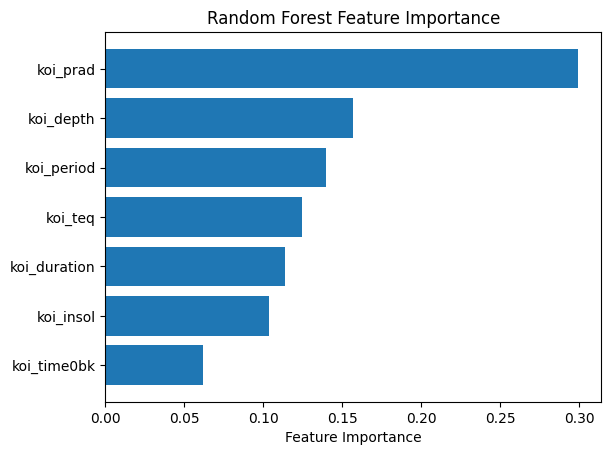

In [23]:
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()

## With Stellar Features

In [24]:
df_kp_s = data[['koi_pdisposition', 'koi_period', 'koi_time0bk', 'koi_duration', 'koi_depth', 'koi_teq',
'koi_prad', 'koi_insol', 'koi_smet', 'koi_steff', 'koi_srad', 'koi_slogg']]

In [25]:
df_kp_s.dropna()

,koi_pdisposition,koi_period,koi_time0bk,koi_duration,koi_depth,koi_teq,koi_prad,koi_insol,koi_smet,koi_steff,koi_srad,koi_slogg
0,CANDIDATE,9.488036,170.538750,2.95750,615.8,793.0,2.26,93.59,0.14,5455.0,0.927,4.467
1,CANDIDATE,54.418383,162.513840,4.50700,874.8,443.0,2.83,9.11,0.14,5455.0,0.927,4.467
2,CANDIDATE,19.899140,175.850252,1.78220,10829.0,638.0,14.60,39.30,-0.18,5853.0,0.868,4.544
3,FALSE POSITIVE,1.736952,170.307565,2.40641,8079.2,1395.0,33.46,891.96,-0.52,5805.0,0.791,4.564
4,CANDIDATE,2.525592,171.595550,1.65450,603.3,1406.0,2.75,926.16,0.07,6031.0,1.046,4.438
...,...,...,...,...,...,...,...,...,...,...,...,...
9559,FALSE POSITIVE,0.527699,131.705093,3.22210,1579.2,2088.0,29.35,4500.53,0.14,5638.0,0.903,4.529
9560,CANDIDATE,1.739849,133.001270,3.11400,48.5,1608.0,0.72,1585.81,-0.04,6119.0,1.031,4.444
9561,FALSE POSITIVE,0.681402,132.181750,0.86500,103.6,2218.0,1.07,5713.41,-0.04,6173.0,1.041,4.447
9562,CANDIDATE,333.486169,153.615010,3.19900,639.1,557.0,19.30,22.68,0.07,4989.0,7.824,2.992


In [26]:
# --- label encoding ---
le_disp = LabelEncoder()
df_kp_s['koi_pdisposition'] = le_disp.fit_transform(df_kp_s['koi_pdisposition'])

/tmp/ipython-input-1059155772.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kp_s['koi_pdisposition'] = le_disp.fit_transform(df_kp_s['koi_pdisposition'])


In [27]:
X = df_kp_s.drop('koi_pdisposition', axis = 1)
y = df_kp_s['koi_pdisposition'].values

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42)

In [29]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [30]:
rf = RandomForestClassifier(
    n_estimators= 340,
    criterion= 'gini',
    bootstrap = False,
    min_samples_split= 10,
    min_samples_leaf= 8
)

In [31]:
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(bootstrap=False, min_samples_leaf=8,
                       min_samples_split=10, n_estimators=340)

In [32]:
y_pred_s = rf.predict(X_test_scaled)

In [33]:
acc_s = accuracy_score(y_test, y_pred_s)
acc_s

0.814427600627287

In [34]:
recall_s = recall_score(y_test, y_pred_s)
recall_s

0.8150903294367694

In [35]:
precision_s = precision_score(y_test, y_pred_s)
precision_s

0.8090717299578059

In [36]:
cm_s = confusion_matrix(y_test, y_pred_s)
cm_s

array([[791, 181],
       [174, 767]])

In [37]:
importances = rf.feature_importances_

feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

feature_importance_df

,feature,importance
5,koi_prad,0.266270
3,koi_depth,0.129155
0,koi_period,0.107211
4,koi_teq,0.096661
6,koi_insol,0.096240
2,koi_duration,0.092511
7,koi_smet,0.073909
1,koi_time0bk,0.039723
8,koi_steff,0.034327
9,koi_srad,0.033149


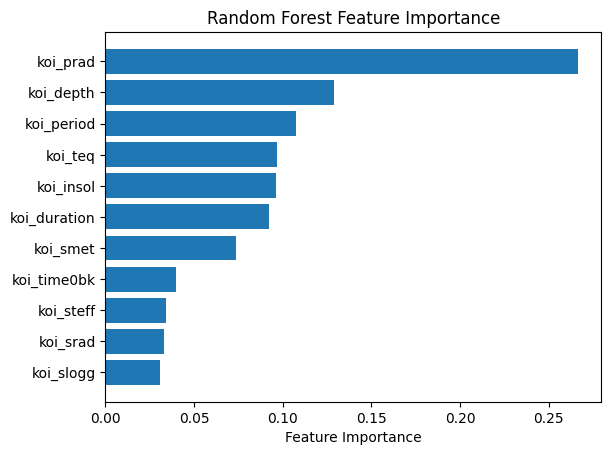

In [38]:
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()

### Features based on Feature Importance

In [39]:
df_kp_fi = data[['koi_pdisposition', 'koi_period', 'koi_time0bk', 'koi_duration', 'koi_depth', 'koi_teq',
'koi_prad', 'koi_insol', 'koi_smet']]

In [40]:
df_kp_fi.dropna()

,koi_pdisposition,koi_period,koi_time0bk,koi_duration,koi_depth,koi_teq,koi_prad,koi_insol,koi_smet
0,CANDIDATE,9.488036,170.538750,2.95750,615.8,793.0,2.26,93.59,0.14
1,CANDIDATE,54.418383,162.513840,4.50700,874.8,443.0,2.83,9.11,0.14
2,CANDIDATE,19.899140,175.850252,1.78220,10829.0,638.0,14.60,39.30,-0.18
3,FALSE POSITIVE,1.736952,170.307565,2.40641,8079.2,1395.0,33.46,891.96,-0.52
4,CANDIDATE,2.525592,171.595550,1.65450,603.3,1406.0,2.75,926.16,0.07
...,...,...,...,...,...,...,...,...,...
9559,FALSE POSITIVE,0.527699,131.705093,3.22210,1579.2,2088.0,29.35,4500.53,0.14
9560,CANDIDATE,1.739849,133.001270,3.11400,48.5,1608.0,0.72,1585.81,-0.04
9561,FALSE POSITIVE,0.681402,132.181750,0.86500,103.6,2218.0,1.07,5713.41,-0.04
9562,CANDIDATE,333.486169,153.615010,3.19900,639.1,557.0,19.30,22.68,0.07


In [41]:
le_disp = LabelEncoder()
df_kp_fi['koi_pdisposition'] = le_disp.fit_transform(df_kp_fi['koi_pdisposition'])

/tmp/ipython-input-620233879.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kp_fi['koi_pdisposition'] = le_disp.fit_transform(df_kp_fi['koi_pdisposition'])


In [42]:
X = df_kp_fi.drop('koi_pdisposition', axis = 1)
y = df_kp_fi['koi_pdisposition'].values

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42)

In [44]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [45]:
rf = RandomForestClassifier(
    n_estimators= 340,
    criterion= 'gini',
    bootstrap = False,
    min_samples_split= 10,
    min_samples_leaf= 8
)

In [46]:
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(bootstrap=False, min_samples_leaf=8,
                       min_samples_split=10, n_estimators=340)

In [47]:
y_pred_fi = rf.predict(X_test_scaled)

In [48]:
acc_fi = accuracy_score(y_test, y_pred_fi)
acc_fi

0.8149503397804495

In [49]:
recall_fi = recall_score(y_test, y_pred_fi)
recall_fi

0.8161530286928799

In [50]:
precision_fi = precision_score(y_test, y_pred_fi)
precision_fi

0.80927291886196

In [51]:
cm_fi = confusion_matrix(y_test, y_pred_fi)
cm_fi

array([[791, 181],
       [173, 768]])

In [52]:
importances = rf.feature_importances_

feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

feature_importance_df

,feature,importance
5,koi_prad,0.277754
3,koi_depth,0.145207
0,koi_period,0.122873
4,koi_teq,0.111526
6,koi_insol,0.105574
2,koi_duration,0.097168
7,koi_smet,0.087054
1,koi_time0bk,0.052844


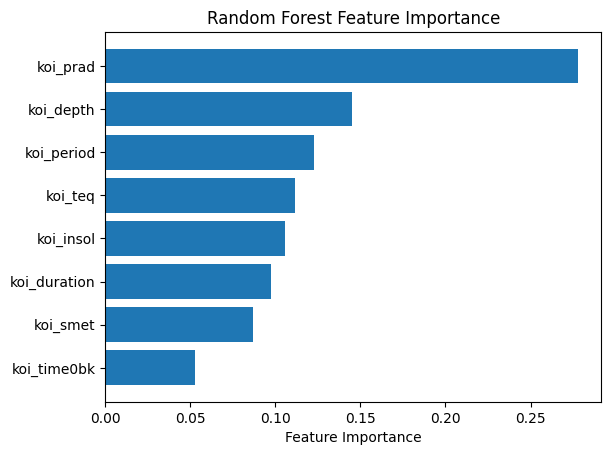

In [53]:
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()

# Based on 'Literature Review'

In [54]:
df_lr = data[['koi_pdisposition','koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec', 'koi_max_mult_ev', 'koi_model_chisq', 'koi_model_snr', 'koi_num_transits', 'koi_impact', 'koi_srho', 'koi_fwm_srao', 'koi_dicco_msky']]

In [55]:
df_lr.dropna()

,koi_pdisposition,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_max_mult_ev,koi_model_chisq,koi_model_snr,koi_num_transits,koi_impact,koi_srho,koi_fwm_srao,koi_dicco_msky


In [56]:
# --- label encoding ---
le_disp = LabelEncoder()
df_lr['koi_pdisposition'] = le_disp.fit_transform(df_lr['koi_pdisposition'])

/tmp/ipython-input-1066677855.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lr['koi_pdisposition'] = le_disp.fit_transform(df_lr['koi_pdisposition'])


In [57]:
X = df_lr.drop('koi_pdisposition', axis = 1)
y = df_lr['koi_pdisposition'].values

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42)

In [59]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [60]:
rf = RandomForestClassifier(
    n_estimators= 340,
    criterion= 'gini',
    bootstrap = False,
    min_samples_split= 10,
    min_samples_leaf= 8
)

In [61]:
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(bootstrap=False, min_samples_leaf=8,
                       min_samples_split=10, n_estimators=340)

In [62]:
y_pred_lr = rf.predict(X_test_scaled)

In [63]:
acc_lr = accuracy_score(y_test, y_pred_lr)
acc_lr

0.9916361735493988

In [64]:
recall_lr = recall_score(y_test, y_pred_lr)
recall_lr

0.9914984059511158

In [65]:
precision_lr = precision_score(y_test, y_pred_lr)
precision_lr

0.9914984059511158

In [66]:
cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_lr

array([[964,   8],
       [  8, 933]])

In [67]:
importances = rf.feature_importances_

feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

feature_importance_df

,feature,importance
0,koi_fpflag_nt,0.245726
1,koi_fpflag_ss,0.226312
2,koi_fpflag_co,0.161688
11,koi_dicco_msky,0.097160
4,koi_max_mult_ev,0.077246
3,koi_fpflag_ec,0.061456
6,koi_model_snr,0.039809
7,koi_num_transits,0.031322
8,koi_impact,0.024873
10,koi_fwm_srao,0.020292


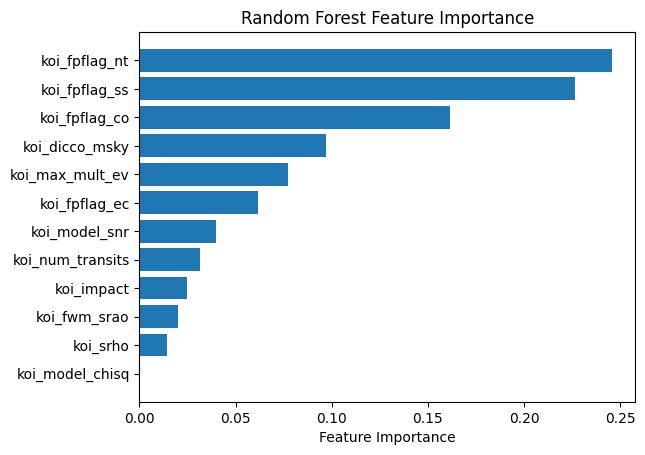

In [68]:
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()

# Remove Not important features

In [69]:
df_lr_fi = data[['koi_pdisposition','koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec', 'koi_max_mult_ev', 'koi_model_snr', 'koi_num_transits', 'koi_impact', 'koi_dicco_msky']]

In [70]:
df_lr_fi.dropna()

,koi_pdisposition,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_max_mult_ev,koi_model_snr,koi_num_transits,koi_impact,koi_dicco_msky
0,CANDIDATE,0,0,0,0,28.470820,35.8,142.0,0.146,0.200
1,CANDIDATE,0,0,0,0,20.109507,25.8,25.0,0.586,0.390
2,CANDIDATE,0,0,0,0,187.449100,76.3,56.0,0.969,0.042
3,FALSE POSITIVE,0,1,0,0,541.895100,505.6,621.0,1.276,0.289
4,CANDIDATE,0,0,0,0,33.191900,40.9,515.0,0.701,0.100
...,...,...,...,...,...,...,...,...,...,...
9559,FALSE POSITIVE,0,1,1,0,223.141400,453.3,2026.0,1.252,2.763
9560,CANDIDATE,0,0,0,0,8.569540,10.6,766.0,0.043,0.780
9561,FALSE POSITIVE,0,0,1,0,9.653322,12.3,1969.0,0.147,5.000
9562,CANDIDATE,0,0,0,0,7.240365,14.0,3.0,0.214,1.690


In [71]:
# --- label encoding ---
le_disp = LabelEncoder()
df_lr_fi['koi_pdisposition'] = le_disp.fit_transform(df_lr_fi['koi_pdisposition'])

/tmp/ipython-input-3886808065.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lr_fi['koi_pdisposition'] = le_disp.fit_transform(df_lr_fi['koi_pdisposition'])


In [72]:
X = df_lr_fi.drop('koi_pdisposition', axis = 1)
y = df_lr_fi['koi_pdisposition'].values

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42)

In [74]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [75]:
rf = RandomForestClassifier(
    n_estimators= 340,
    criterion= 'gini',
    bootstrap = False,
    min_samples_split= 10,
    min_samples_leaf= 8
)

In [76]:
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(bootstrap=False, min_samples_leaf=8,
                       min_samples_split=10, n_estimators=340)

In [77]:
y_pred_lr_fi = rf.predict(X_test_scaled)

In [78]:
acc_lr_fi = accuracy_score(y_test, y_pred_lr_fi)
acc_lr_fi

0.9884997386304234

In [79]:
recall_lr_fi = recall_score(y_test, y_pred_lr_fi)
recall_lr_fi

0.9872476089266737

In [80]:
precision_lr_fi = precision_score(y_test, y_pred_lr_fi)
precision_lr_fi

0.9893503727369543

In [81]:
cm_lr_fi = confusion_matrix(y_test, y_pred_lr_fi)
cm_lr_fi

array([[962,  10],
       [ 12, 929]])

In [82]:
importances = rf.feature_importances_

feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

feature_importance_df

,feature,importance
0,koi_fpflag_nt,0.262546
1,koi_fpflag_ss,0.249088
2,koi_fpflag_co,0.171655
8,koi_dicco_msky,0.105544
4,koi_max_mult_ev,0.061599
3,koi_fpflag_ec,0.061310
5,koi_model_snr,0.040481
6,koi_num_transits,0.025224
7,koi_impact,0.022553


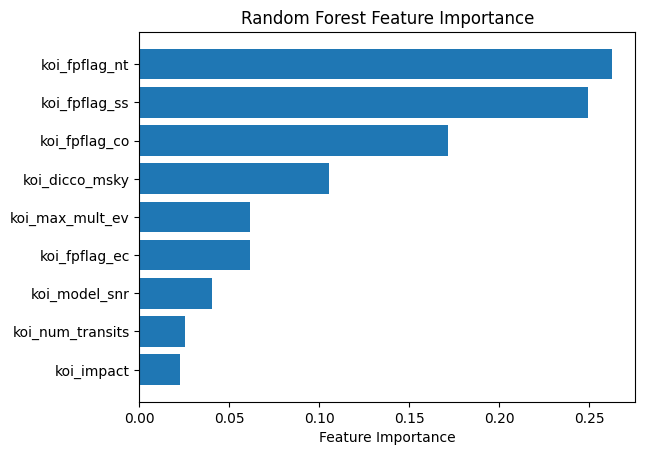

In [83]:
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()

# Using SuperSet of all important features

In [84]:
# df_imp = data[['koi_pdisposition','koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec',
# 'koi_max_mult_ev', 'koi_model_snr', 'koi_num_transits', 'koi_depth', 'koi_duration',
#                'koi_impact', 'koi_period', 'koi_time0bk',
#                'koi_prad', 'koi_dicco_msky', 'koi_dikco_msky', 'koi_fwm_stat_sig',
#                'koi_steff', 'koi_slogg', 'koi_smet']]

# df_imp = data[['koi_pdisposition',
# 'koi_max_mult_ev', 'koi_model_snr', 'koi_num_transits', 'koi_depth', 'koi_duration',
#                'koi_impact', 'koi_period', 'koi_time0bk',
#                'koi_prad', 'koi_dicco_msky', 'koi_dikco_msky', 'koi_fwm_stat_sig',
#                'koi_steff', 'koi_slogg', 'koi_smet']]

df_imp = data[['koi_pdisposition',
'koi_period', 'koi_duration', 'koi_depth', 'koi_impact', 'koi_ror',
               'koi_srho', 'koi_prad', 'koi_teq',
               'koi_insol', 'koi_steff', 'koi_slogg', 'koi_smet',
               'koi_smass', 'koi_model_snr', 'koi_model_chisq', 'koi_num_transits']]

In [85]:
df_imp.dropna()

,koi_pdisposition,koi_period,koi_duration,koi_depth,koi_impact,koi_ror,koi_srho,koi_prad,koi_teq,koi_insol,koi_steff,koi_slogg,koi_smet,koi_smass,koi_model_snr,koi_model_chisq,koi_num_transits


In [86]:
# --- label encoding ---
le_disp = LabelEncoder()
df_imp['koi_pdisposition'] = le_disp.fit_transform(df_imp['koi_pdisposition'])

/tmp/ipython-input-905701176.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_imp['koi_pdisposition'] = le_disp.fit_transform(df_imp['koi_pdisposition'])


In [87]:
X = df_imp.drop('koi_pdisposition', axis = 1)
y = df_imp['koi_pdisposition'].values

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42)

In [89]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [90]:
rf = RandomForestClassifier(
    n_estimators= 340,
    criterion= 'gini',
    bootstrap = False,
    min_samples_split= 10,
    min_samples_leaf= 8
)

In [91]:
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(bootstrap=False, min_samples_leaf=8,
                       min_samples_split=10, n_estimators=340)

In [92]:
y_pred_imp = rf.predict(X_test_scaled)

In [93]:
acc_imp = accuracy_score(y_test, y_pred_imp)
acc_imp

0.8342916884474647

In [94]:
recall_imp = recall_score(y_test, y_pred_imp)
recall_imp

0.8416578108395324

In [95]:
precision_imp = precision_score(y_test, y_pred_imp)
precision_imp

0.825

In [96]:
cm_imp = confusion_matrix(y_test, y_pred_imp)
cm_imp

array([[804, 168],
       [149, 792]])

In [97]:
importances = rf.feature_importances_

feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

feature_importance_df

,feature,importance
6,koi_prad,0.168208
4,koi_ror,0.127574
15,koi_num_transits,0.095533
7,koi_teq,0.076757
0,koi_period,0.070275
2,koi_depth,0.069680
5,koi_srho,0.069390
8,koi_insol,0.066150
13,koi_model_snr,0.052366
1,koi_duration,0.050819


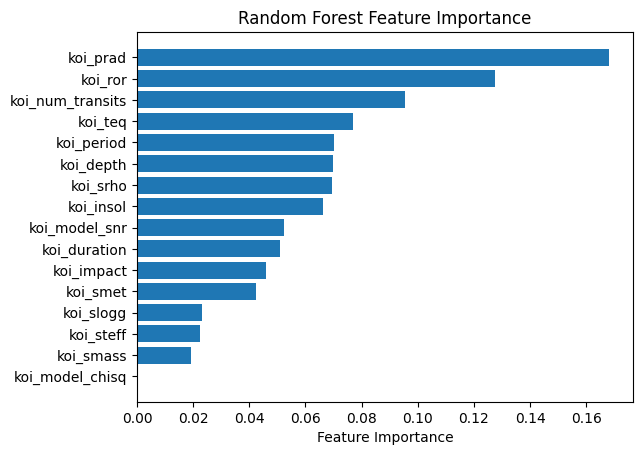

In [98]:
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()

# Our strategy

In [77]:
# df_final = data[['koi_pdisposition','koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec',
# 'koi_max_mult_ev', 'koi_num_transits', 'koi_depth', 'koi_duration','koi_period',
#                'koi_prad', 'koi_dicco_msky', 'koi_dikco_msky', 'koi_fwm_stat_sig']]

# df_final = data[['koi_pdisposition',
# 'koi_period', 'koi_duration', 'koi_depth', 'koi_impact', 'koi_ror',
#                'koi_srho', 'koi_prad', 'koi_teq',
#                'koi_insol', 'koi_smet',
#                'koi_model_snr', 'koi_num_transits']]

df_final = data[['koi_pdisposition',
'koi_period', 'koi_duration', 'koi_depth', 'koi_impact', 'koi_ror',
               'koi_srho', 'koi_prad', 'koi_teq',
               'koi_insol', 'koi_smet',
               'koi_model_snr', 'koi_num_transits']]

In [78]:
le_pdisp = LabelEncoder()
df_final['koi_pdisposition'] = le_pdisp.fit_transform(df_final['koi_pdisposition'])

/tmp/ipython-input-3096111429.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['koi_pdisposition'] = le_pdisp.fit_transform(df_final['koi_pdisposition'])


In [79]:
imputer = KNNImputer(n_neighbors=5)
X = imputer.fit_transform(df_final.drop('koi_pdisposition', axis=1))
y = df_final['koi_pdisposition'].values

In [80]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42)

In [81]:
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.10, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=2/9, random_state=42, stratify=y_trainval
)

In [82]:
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_val_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

In [83]:
# # --- weights for Ensemble ---
# w1, w2 = 0.5931129060965006, 0.13535353285850302
# w3 = 1 - w1 - w2

In [84]:
# --- Models ---
def get_models():
    cat = CatBoostClassifier(
        iterations= 400,
        learning_rate = 0.04216598764315635,
        depth = 6,
        l2_leaf_reg = 3.663779798834057,
        border_count = 116,
        bagging_temperature = 0.17142116748408584,
        random_strength = 4.070004945458448,
    )
    xgb = XGBClassifier(
        n_estimators = 400,
        learning_rate = 0.015603483038026065,
        max_depth= 6,
        subsample= 0.7299759595102386,
        colsample_bytree= 0.8377273956982814,
        min_child_weight= 6,
        gamma= 0.22255269708412592,
        reg_alpha= 0.424023705682538,
        reg_lambda= 0.9913150951095967
    )
    lgbm = LGBMClassifier(
        n_estimators = 800,
        learning_rate = 0.04554947977677974,
        max_depth = 11,
        num_leaves = 63,
        min_child_samples= 26,
        subsample = 0.9706711709803809,
        subsample_freq= 8,
        colsample_bytree= 0.8753746188449917,
        reg_alpha= 0.8081540413430114,
        reg_lambda= 0.6361592585877186,
        min_split_gain= 0.7310816204125187,
    )
    return cat, xgb, lgbm

In [85]:
# --- Train fit ---
cat_model, xgb_model, lgbm_model = get_models()
cat_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)
lgbm_model.fit(X_train, y_train)

0:	learn: 0.6711727	total: 3.88ms	remaining: 1.55s
1:	learn: 0.6502025	total: 7.6ms	remaining: 1.51s
2:	learn: 0.6326762	total: 11ms	remaining: 1.45s
3:	learn: 0.6166046	total: 14.4ms	remaining: 1.42s
4:	learn: 0.5999306	total: 17.7ms	remaining: 1.4s
5:	learn: 0.5874185	total: 21ms	remaining: 1.38s
6:	learn: 0.5749014	total: 24.3ms	remaining: 1.36s
7:	learn: 0.5624441	total: 27.7ms	remaining: 1.36s
8:	learn: 0.5569391	total: 30ms	remaining: 1.3s
9:	learn: 0.5471982	total: 33.5ms	remaining: 1.3s
10:	learn: 0.5377490	total: 37.2ms	remaining: 1.31s
11:	learn: 0.5277335	total: 40.7ms	remaining: 1.31s
12:	learn: 0.5194931	total: 44.2ms	remaining: 1.32s
13:	learn: 0.5132222	total: 47.7ms	remaining: 1.31s
14:	learn: 0.5067024	total: 51.1ms	remaining: 1.31s
15:	learn: 0.5014836	total: 54.8ms	remaining: 1.31s
16:	learn: 0.4951019	total: 58.6ms	remaining: 1.32s
17:	learn: 0.4893122	total: 62.1ms	remaining: 1.32s
18:	learn: 0.4834413	total: 65.7ms	remaining: 1.32s
19:	learn: 0.4768464	total: 69.4

LGBMClassifier(colsample_bytree=0.8753746188449917,
               learning_rate=0.04554947977677974, max_depth=11,
               min_child_samples=26, min_split_gain=0.7310816204125187,
               n_estimators=800, num_leaves=63, reg_alpha=0.8081540413430114,
               reg_lambda=0.6361592585877186, subsample=0.9706711709803809,
               subsample_freq=8)

In [86]:
import optuna
import numpy as np
from sklearn.metrics import f1_score

# First, get predictions from each model on validation set
cat_val_proba = cat_model.predict_proba(X_val)
xgb_val_proba = xgb_model.predict_proba(X_val)
lgbm_val_proba = lgbm_model.predict_proba(X_val)

def objective_ensemble(trial):
    # Suggest weights that sum to 1
    w1 = trial.suggest_float('w_catboost', 0.0, 1.0)
    w2 = trial.suggest_float('w_xgboost', 0.0, 1.0)
    w3 = trial.suggest_float('w_lightgbm', 0.0, 1.0)

    # Normalize weights to sum to 1
    total = w1 + w2 + w3
    w1, w2, w3 = w1/total, w2/total, w3/total

    # Weighted ensemble
    ensemble_proba = w1 * cat_val_proba + w2 * xgb_val_proba + w3 * lgbm_val_proba
    ensemble_pred = np.argmax(ensemble_proba, axis=1)

    # Calculate F1 score
    score = f1_score(y_val, ensemble_pred)

    return score

# Optimize
study_ensemble = optuna.create_study(direction='maximize')
study_ensemble.optimize(objective_ensemble, n_trials=200)

print("Best ensemble weights:", study_ensemble.best_params)
print("Best F1 score:", study_ensemble.best_value)

# Get normalized weights
best_w1 = study_ensemble.best_params['w_catboost']
best_w2 = study_ensemble.best_params['w_xgboost']
best_w3 = study_ensemble.best_params['w_lightgbm']
total = best_w1 + best_w2 + best_w3
best_w1, best_w2, best_w3 = best_w1/total, best_w2/total, best_w3/total

print(f"\nNormalized weights:")
print(f"CatBoost: {best_w1:.4f}")
print(f"XGBoost: {best_w2:.4f}")
print(f"LightGBM: {best_w3:.4f}")

[I 2026-01-12 14:55:35,351] A new study created in memory with name: no-name-241d834e-d3ac-447f-a4e5-27a560ed7183
[I 2026-01-12 14:55:35,362] Trial 0 finished with value: 0.8221052631578948 and parameters: {'w_catboost': 0.9780560239744697, 'w_xgboost': 0.6097606658766532, 'w_lightgbm': 0.1812833247451744}. Best is trial 0 with value: 0.8221052631578948.
[I 2026-01-12 14:55:35,368] Trial 1 finished with value: 0.8242105263157895 and parameters: {'w_catboost': 0.8979057214682185, 'w_xgboost': 0.6351557320765872, 'w_lightgbm': 0.2341263993129915}. Best is trial 1 with value: 0.8242105263157895.
[I 2026-01-12 14:55:35,373] Trial 2 finished with value: 0.8268625393494229 and parameters: {'w_catboost': 0.85422339317401, 'w_xgboost': 0.5762162429154856, 'w_lightgbm': 0.3573066793290415}. Best is trial 2 with value: 0.8268625393494229.
[I 2026-01-12 14:55:35,378] Trial 3 finished with value: 0.8261780104712042 and parameters: {'w_catboost': 0.387373786017544, 'w_xgboost': 0.3810001735647409, 

Best ensemble weights: {'w_catboost': 0.5862776755846135, 'w_xgboost': 0.10382886817412462, 'w_lightgbm': 0.7143400263515646}
Best F1 score: 0.8284518828451883

Normalized weights:
CatBoost: 0.4174
XGBoost: 0.0739
LightGBM: 0.5086


In [88]:
w1 = 0.4174 #CatBoost:
w2 = 0.0739 #XGBoost:
w3 = 0.5086 #LightGBM:

In [89]:
# --- Validation Ensemble ---
cat_val = cat_model.predict_proba(X_val)
xgb_val = xgb_model.predict_proba(X_val)
lgbm_val = lgbm_model.predict_proba(X_val)

In [90]:
ensemble_val = (w1 * cat_val + w2 * xgb_val + w3 * lgbm_val)
ensemble_val_pred = np.argmax(ensemble_val, axis=1)

In [91]:
print("\n--- VALIDATION Metrics----")
print("Accuracy:", accuracy_score(y_val, ensemble_val_pred))
print("Precision:", precision_score(y_val, ensemble_val_pred, average="macro"))
print("Recall:", recall_score(y_val, ensemble_val_pred, average="macro"))
print("F1:", f1_score(y_val, ensemble_val_pred, average="macro"))
print("Confusion Matrix:\n", confusion_matrix(y_val, ensemble_val_pred))


--- VALIDATION Metrics----
Accuracy: 0.8285415577626765
Precision: 0.8287240811560739
Recall: 0.8287140186507199
F1: 0.8285415109105774
Confusion Matrix:
 [[793 150]
 [178 792]]


In [98]:
cat_test = cat_model.predict_proba(X_test)
xgb_test = xgb_model.predict_proba(X_test)
lgbm_test = lgbm_model.predict_proba(X_test)

In [99]:
ensemble_test = (w1 * cat_test + w2 * xgb_test + w3 * lgbm_test)
ensemble_test_pred = np.argmax(ensemble_test, axis=1)

In [100]:
print("\n--- TEST  Metrics---")
print("Accuracy:", accuracy_score(y_test, ensemble_test_pred))
print("F1:", f1_score(y_test, ensemble_test_pred, average="macro"))
print("Recall:", recall_score(y_test, ensemble_test_pred, average="micro"))



--- TEST  Metrics---
Accuracy: 0.832810867293626
F1: 0.8328092243186582
Recall: 0.832810867293626


In [112]:
# # --- 20-Fold Ensemble Cross Validation ---
# kf = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)
# fold_acc = []

In [113]:
# print("\n--- 20-Fold Ensemble Cross Validation ---")
# for i, (train_idx, val_idx) in enumerate(kf.split(X, y), 1):
#     X_tr, X_va = X[train_idx], X[val_idx]
#     y_tr, y_va = y[train_idx], y[val_idx]

#     cat, xgb, lgbm = get_models()
#     cat.fit(X_tr, y_tr)
#     xgb.fit(X_tr, y_tr)
#     lgbm.fit(X_tr, y_tr)

#     cat_p = cat.predict_proba(X_va)
#     xgb_p = xgb.predict_proba(X_va)
#     lgbm_p = lgbm.predict_proba(X_va)

#     ensemble_p = (w1 * cat_p + w2 * xgb_p + w3 * lgbm_p)
#     ensemble_pred = np.argmax(ensemble_p, axis=1)

#     acc = accuracy_score(y_va, ensemble_pred)
#     fold_acc.append(acc)
#     print(f"Fold {i}: ACC = {acc:.4f}")

In [114]:
# print("\n--- K-Fold Summary ---")
# print("Average ACCURACY:", np.mean(fold_acc))
# print("Best Fold ACCURACY:", np.max(fold_acc))

In [115]:
# # --- K-Fold graph ---
# plt.figure(figsize=(10,5))
# plt.plot(range(1, 21), fold_acc, marker='o')
# plt.title("20-Fold Cross Validation Accuracy (Ensemble)")
# plt.xlabel("Fold")
# plt.ylabel("Accuracy")
# plt.grid(True)
# plt.show()

# Only Using the best model

In [166]:
df_bst = data[['koi_pdisposition',
'koi_period', 'koi_duration', 'koi_depth', 'koi_ror',
               'koi_srho', 'koi_prad', 'koi_teq',
               'koi_insol', 'koi_smet',
               'koi_model_snr', 'koi_num_transits']]

In [167]:
le_pdisp = LabelEncoder()
df_bst['koi_pdisposition'] = le_pdisp.fit_transform(df_bst['koi_pdisposition'])

/tmp/ipython-input-2081019987.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bst['koi_pdisposition'] = le_pdisp.fit_transform(df_bst['koi_pdisposition'])


In [168]:
imputer = KNNImputer(n_neighbors=5)
X = imputer.fit_transform(df_bst.drop('koi_pdisposition', axis=1))
y = df_bst['koi_pdisposition'].values

In [169]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42)

In [170]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [171]:
cat = CatBoostClassifier(
        iterations= 400,
        learning_rate = 0.04216598764315635,
        depth = 6,
        l2_leaf_reg = 3.663779798834057,
        border_count = 116,
        bagging_temperature = 0.17142116748408584,
        random_strength = 4.070004945458448)

In [172]:
cat.fit(X_train_scaled, y_train)

0:	learn: 0.6721214	total: 11.3ms	remaining: 4.52s
1:	learn: 0.6530221	total: 19.6ms	remaining: 3.91s
2:	learn: 0.6369154	total: 29ms	remaining: 3.84s
3:	learn: 0.6186622	total: 40.3ms	remaining: 3.98s
4:	learn: 0.6042114	total: 49.3ms	remaining: 3.9s
5:	learn: 0.5924787	total: 58.9ms	remaining: 3.87s
6:	learn: 0.5809293	total: 67.2ms	remaining: 3.77s
7:	learn: 0.5666600	total: 78.5ms	remaining: 3.85s
8:	learn: 0.5565819	total: 87.5ms	remaining: 3.8s
9:	learn: 0.5449844	total: 97.5ms	remaining: 3.8s
10:	learn: 0.5357278	total: 109ms	remaining: 3.85s
11:	learn: 0.5268816	total: 119ms	remaining: 3.83s
12:	learn: 0.5170516	total: 128ms	remaining: 3.82s
13:	learn: 0.5096166	total: 139ms	remaining: 3.84s
14:	learn: 0.5019621	total: 148ms	remaining: 3.8s
15:	learn: 0.4956653	total: 158ms	remaining: 3.8s
16:	learn: 0.4888238	total: 174ms	remaining: 3.91s
17:	learn: 0.4829613	total: 189ms	remaining: 4s
18:	learn: 0.4765913	total: 197ms	remaining: 3.94s
19:	learn: 0.4718757	total: 208ms	remaini

In [173]:
y_pred_bst = cat.predict(X_test_scaled)

In [174]:
acc_bst = accuracy_score(y_test, y_pred_bst)

In [175]:
acc_bst

0.8389963408259279

In [151]:
type(X)
type(X_train)

numpy.ndarray

In [176]:
importances = cat.get_feature_importance()

feature_importance_df = pd.DataFrame({
    'feature': df_bst.drop('koi_pdisposition', axis=1).columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

feature_importance_df

,feature,importance
5,koi_prad,18.170153
3,koi_ror,10.868365
4,koi_srho,9.717493
2,koi_depth,9.154048
0,koi_period,9.006211
8,koi_smet,8.694871
9,koi_model_snr,8.443608
1,koi_duration,8.184875
10,koi_num_transits,7.453926
6,koi_teq,5.550498


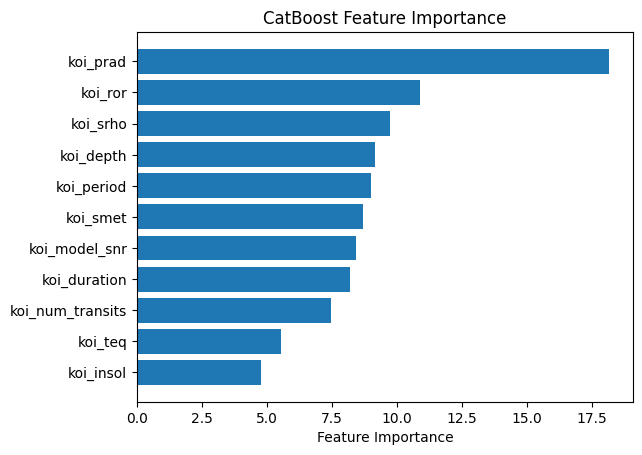

In [177]:
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title("CatBoost Feature Importance")
plt.show()

In [178]:
from catboost import Pool

# Create a CatBoost Pool object from X_train
train_pool = Pool(X_train)

shap_values = cat.get_feature_importance(
    type='ShapValues',
    data=train_pool
)

# Remove expected value column
shap_values = shap_values[:, :-1]

shap_importance = abs(shap_values).mean(axis=0)

shap_df = pd.DataFrame({
    'feature': df_bst.drop('koi_pdisposition', axis=1).columns, # Use original column names
    'importance': shap_importance
}).sort_values(by='importance', ascending=False)

shap_df

,feature,importance
5,koi_prad,1.269656
2,koi_depth,1.032321
3,koi_ror,0.775695
4,koi_srho,0.417055
0,koi_period,0.352469
10,koi_num_transits,0.340502
8,koi_smet,0.274877
7,koi_insol,0.274867
1,koi_duration,0.225418
6,koi_teq,0.225062


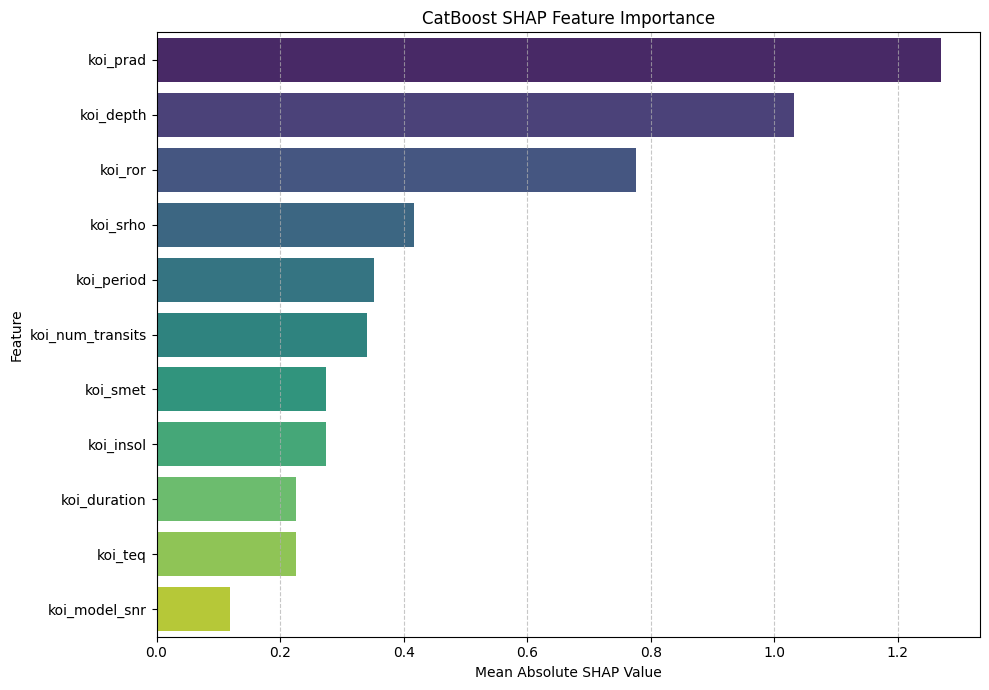

In [179]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
sns.barplot(x='importance', y='feature', data=shap_df, palette='viridis')
plt.xlabel("Mean Absolute SHAP Value")
plt.ylabel("Feature")
plt.title("CatBoost SHAP Feature Importance")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()